This notebook picks up where the other left off, because it's on a local workstation with PyPlot.

In [1]:
using PyPlot
plt[:style][:use]("ggplot")

INFO: Recompiling stale cache file /usr/people/tmacrina/.julia/lib/v0.5/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /usr/people/tmacrina/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


In [11]:
exp_params = Dict()
dir = joinpath(homedir(), "seungmount/research/davit/FilterFinder/data/meshset_inspected")
exp_dirs = ["standard_160", "standard_224", "across_224", "across_160"]
ms_names = ["original", "net_adj", "bandpass", "net_across"]
for exp in exp_dirs
    exp_params[exp] = Dict()
    for ms in ms_names
        fn = join([exp, ms], "_")
        exp_params[exp][ms] = readdlm(joinpath(homedir(), dir, string(fn, "_params.csv")))
    end
end

In [12]:
exp_params

Dict{Any,Any} with 4 entries:
  "across_160"   => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 40.353 … 0.2133…
  "across_224"   => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 37.1512 … 0.140…
  "standard_160" => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 16.5007 … 0.145…
  "standard_224" => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 16.543 … 0.1566…

        filtered[collect(get_rejected_indices(match))] = 0
        dist = get_properties(match, "norm")
        r_max = get_properties(match, "r_max")
        sigma50 = get_properties(match, 0.50)
        sigma75 = get_properties(match, 0.75)
        sigma95 = get_properties(match, 0.95)
        r_delta5 = get_properties(match, 5)
        r_delta10 = get_properties(match, 10)
        r_delta15 = get_properties(match, 15)
        params = hcat(filtered, dist, r_max, sigma50, sigma75, sigma95, r_delta5, r_delta10, r_delta15)

In [5]:
function plot_meshset_hist(ms_params, total_ms, k)
    axes = []
    for i in 1:8
        subplot(8, total_ms, 8*(k-1)+i)
        binmax = maximum(ms_params[:,i+1])
        
        if binmax != Inf
            bins = collect(linspace(0,binmax,50))
            plt[:hist](ms_params[ms_params[:,1] .== 1, i+1], bins=bins, color="g", alpha=0.3)
            plt[:hist](ms_params[ms_params[:,1] .== 0, i+1], bins=bins, color="r", alpha=0.3)
        end
        ax = gca()
        ax[:set_ylim]((0.5,10e5))
        ax[:set_yscale]("log")
        push!(axes, ax)
    end
    return axes
end

plot_meshset_hist (generic function with 1 method)

In [78]:
standard_224 = exp_params["standard_224"]

Dict{Any,Any} with 4 entries:
  "bandpass"   => [1.0 16.543 … 0.156665 0.156665; 1.0 16.5923 … 0.239579 0.239…
  "original"   => [1.0 16.5949 … 0.157133 0.170258; 1.0 16.6178 … 0.256364 0.27…
  "net_adj"    => [1.0 17.1376 … 0.435392 0.435392; 1.0 17.1393 … 0.564224 0.61…
  "net_across" => [1.0 16.6307 … 0.399027 0.399027; 1.0 17.1251 … 0.556363 0.55…

In [70]:
function plot_meshset_hist_modified(ms_params, total_ms, k)
    axes = []
    ls = [1,2,6] # norm, r_max, r_delta
    for (i,j) in enumerate(ls)
        subplot(4, total_ms, 3*(k-1)+i)
        ax = gca()
        ax[:set_ylim]((0.5,10e5))
        ax[:set_yscale]("log")
        binmax = maximum(ms_params[:,j+1])
        if binmax == Inf
            binmax = 1
        end
        if j == 2
            ax[:set_xlim]((0,1))
            binmax = 1
        elseif j == 6
            ax[:set_xlim]((0,0.6))
            binmax = 0.6
        end
        bins = collect(linspace(0,binmax,50))
        if binmax != Inf
            plt[:hist](ms_params[ms_params[:,1] .== 1, j+1], bins=bins, color="g", alpha=0.3)
            plt[:hist](ms_params[ms_params[:,1] .== 0, j+1], bins=bins, color="r", alpha=0.3) 
        end
        push!(axes, ax)
    end
    return axes
end

plot_meshset_hist_modified (generic function with 1 method)

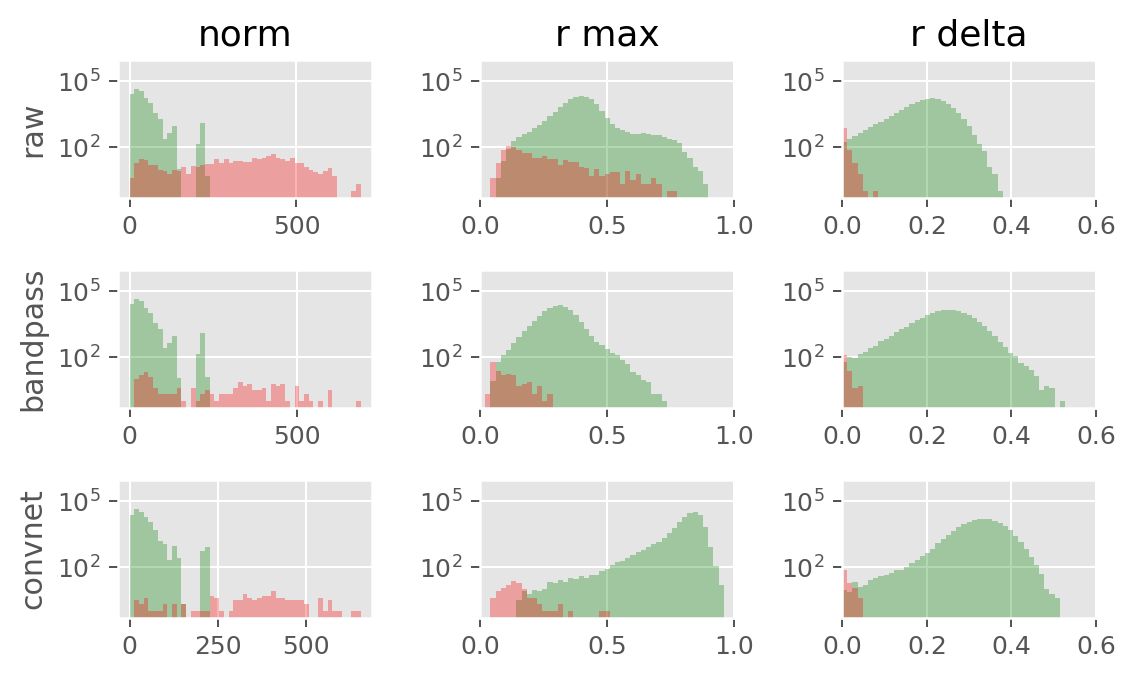

In [71]:
rows = ["raw", "bandpass", "convnet"]
cols = ["norm", "r max", "r delta"]
fig = figure(dpi=180)
axes = Array{PyCall.PyObject,2}(length(rows),length(cols))
for (k, ms_name) in enumerate(rows)
    if ms_name == "convnet"
        ms_name = "net_adj"
    end
    if ms_name == "raw"
        ms_name = "original"
    end
    ms_params = standard_224[ms_name]
    axes[k,:] = plot_meshset_hist_modified(ms_params, 3, k)
end

for (ax, col) in zip(axes[1,:], cols)
    ax[:set_title](col) #, fontsize=24)
end
for (ax, row) in zip(axes[:,1], rows)
    ax[:set_ylabel](row) #, fontsize=24)
end
fig[:tight_layout]()
plt[:show]()

In [24]:
"""
Compile precision & recall on param data

f: binary array of labels
d: data array
x: range of thresholds to plot p&r against
"""
function compile_precision_recall(f, d, x)
    n = length(f)
    tp = zeros(Int64, length(x))
    fn = zeros(Int64, length(x))
    fp = zeros(Int64, length(x))
    for (k,z) in enumerate(x)
        tp[k] = sum(f[d .> z] .== 1)
        fp[k] = sum(f[d .> z] .== 0)
        fn[k] = sum(f[d .<= z] .== 1)
    end
    precision = tp ./ (tp + fp)
    recall = tp ./ (tp + fn)
    f1 = 2*tp ./ (2*tp + fp + fn)
    return precision, recall, f1
end        

compile_precision_recall

In [25]:
"""
Compile tp, fp, fn, tn

f: binary array of labels
d: data array
x: range of thresholds to plot p&r against
"""
function compile_rejection_accuracy(f, d, x)
    n = length(f)
    tp = zeros(Int64, length(x))
    fn = zeros(Int64, length(x))
    fp = zeros(Int64, length(x))
    tn = zeros(Int64, length(x))
    for (k,z) in enumerate(x)
        tp[k] = sum(f[d .> z] .== 1)
        fp[k] = sum(f[d .> z] .== 0)
        fn[k] = sum(f[d .<= z] .== 1)
        tn[k] = sum(f[d .<= z] .== 0)
    end
    return tp, fp, fn, tn
end  

compile_rejection_accuracy

In [73]:
x = collect(linspace(0,1,300))
nar_f = standard_224["net_adj"][:,1]
nar_d = standard_224["net_adj"][:,7]
bpr_f = standard_224["bandpass"][:,1]
bpr_d = standard_224["bandpass"][:,7]
opr_f = standard_224["original"][:,1]
opr_d = standard_224["original"][:,7]
na_tp, na_fp, na_fn, na_tn = compile_rejection_accuracy(nar_f, nar_d, x)
bp_tp, bp_fp, bp_fn, bp_tn = compile_rejection_accuracy(bpr_f, bpr_d, x);
o_tp, o_fp, o_fn, o_tn = compile_rejection_accuracy(opr_f, opr_d, x);

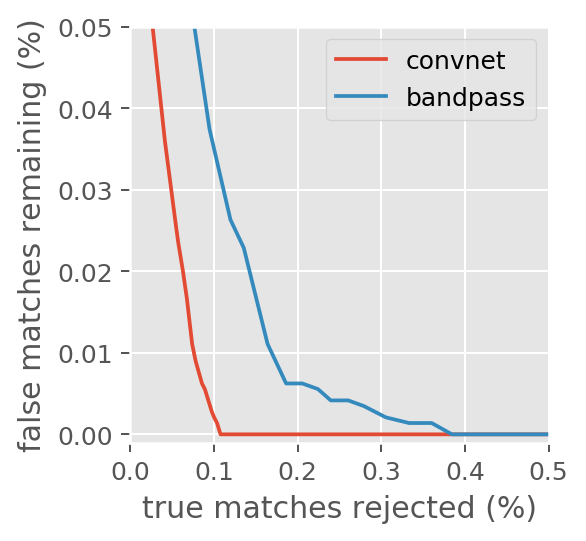

In [85]:
fig = figure(figsize=(3,3), dpi=180)
plot((na_fn + na_tn)/sum(nar_f) * 100, (1 - na_tp ./ (na_fp + na_tp))*100, label="convnet")
plot((bp_fn + bp_tn)/sum(bpr_f) * 100, (1 - bp_tp ./ (bp_fp + bp_tp))*100, label="bandpass")
ax = gca()
xlabel("true matches rejected (%)")
ylabel("false matches remaining (%)")
ax[:set_xlim]((0,0.5))
ax[:set_ylim]((-0.001,0.05))
legend(loc="best");

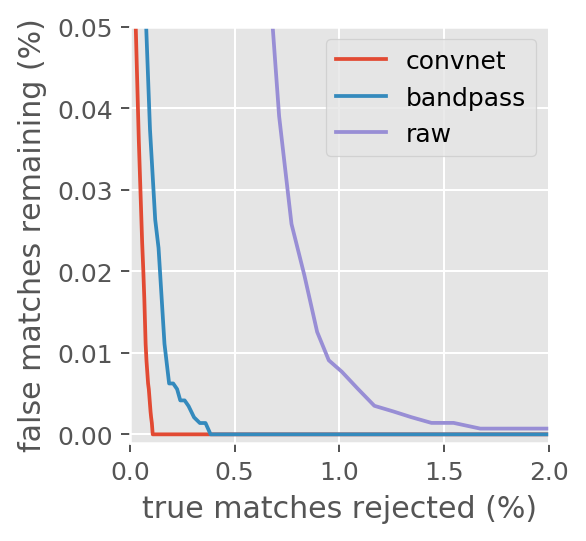

In [86]:
fig = figure(figsize=(3,3), dpi=180)
plot((na_fn + na_tn)/sum(nar_f) * 100, (1 - na_tp ./ (na_fp + na_tp))*100, label="convnet")
plot((bp_fn + bp_tn)/sum(bpr_f) * 100, (1 - bp_tp ./ (bp_fp + bp_tp))*100, label="bandpass")
plot((o_fn + o_tn)/sum(opr_f) * 100, (1 - o_tp ./ (o_fp + o_tp))*100, label="raw")
ax = gca()
xlabel("true matches rejected (%)")
ylabel("false matches remaining (%)")
ax[:set_xlim]((0,2.0))
ax[:set_ylim]((-0.001,0.05))
legend(loc="best");